In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class BallAndGoalEnv(gym.Env):
    def __init__(self):
        super(BallAndGoalEnv, self).__init__()
        # Action space: 0 = move left, 1 = move right
        self.action_space = spaces.Discrete(2)
        # Observation space: Current position (1D space)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(1,), dtype=np.float32)
        
        self.position = 0  # Ball's starting position
        self.goal = 5  # Target position
        self.max_steps = 20
        self.current_step = 0

    def reset(self, seed=None, options=None):
        self.position = 0
        self.current_step = 0
        return np.array([self.position], dtype=np.float32), {}

    def step(self, action):
        # Update position based on action
        if action == 0:  # Move left
            self.position -= 1
        elif action == 1:  # Move right
            self.position += 1

        # Calculate reward (negative distance to goal)
        distance_to_goal = abs(self.goal - self.position)
        reward = -distance_to_goal

        # Add a small step penalty to encourage efficiency
        reward -= 0.1

        # Check if done
        self.current_step += 1
        done = self.position == self.goal or self.current_step >= self.max_steps

        # No truncation in this environment
        truncated = False

        return np.array([self.position], dtype=np.float32), reward, done, truncated, {}

    def render(self, mode="human"):
        print(f"Position: {self.position}, Goal: {self.goal}")

    def close(self):
        pass


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -95      |
| time/              |          |
|    fps             | 2534     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.9        |
|    ep_rew_mean          | -71.4       |
| time/                   |             |
|    fps                  | 1699        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010864267 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss   

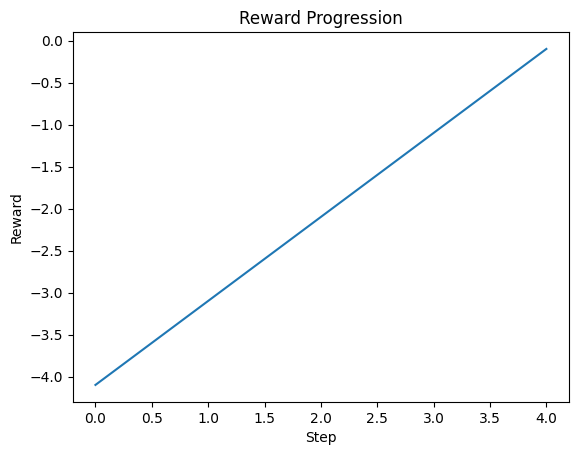

In [6]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Initialize the environment
env = BallAndGoalEnv()

# Initialize PPO
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
timesteps = 100000
model.learn(total_timesteps=timesteps)

# Save the model
model.save("ppo_ball_and_goal")

# Evaluate the model
env = BallAndGoalEnv()
obs, info = env.reset()
done = False
reward_list = []
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

    env.render()

# Plot rewards
plt.plot(reward_list)
plt.title("Reward Progression")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()

In [8]:
import pygame
from stable_baselines3 import PPO

# Initialize Pygame
pygame.init()

# Screen dimensions
WIDTH, HEIGHT = 800, 400
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Ball and Goal Animation with PPO")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)

# Ball and Goal positions
BALL_RADIUS = 15
GOAL_POSITION = WIDTH - 100
START_POSITION = 100

# Load the PPO model
model = PPO.load("ppo_ball_and_goal")

# Initialize environment variables
ball_position = START_POSITION
goal_position = GOAL_POSITION
step_count = 0
total_reward = 0

# Clock for controlling the frame rate
clock = pygame.time.Clock()

# Main function
def main():
    global ball_position, step_count, total_reward

    running = True
    obs = np.array([0], dtype=np.float32)  # Initial observation (position = 0)

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        
        # Get action from the trained PPO model
        action, _ = model.predict(obs, deterministic=True)

        # Update ball position based on action
        if action == 0:  # Move left
            ball_position = max(START_POSITION, ball_position - 10)
        elif action == 1:  # Move right
            ball_position = min(GOAL_POSITION, ball_position + 10)

        # Update observation and step count
        obs = np.array([(ball_position - START_POSITION) / (GOAL_POSITION - START_POSITION) * 10], dtype=np.float32)
        step_count += 1

        # Clear screen
        screen.fill(WHITE)

        # Draw goal
        pygame.draw.rect(screen, RED, (goal_position - 5, HEIGHT // 2 - 30, 10, 60))

        # Draw ball
        pygame.draw.circle(screen, BLUE, (ball_position, HEIGHT // 2), BALL_RADIUS)

        # Display text
        font = pygame.font.Font(None, 36)
        step_text = font.render(f"Steps: {step_count}", True, BLACK)
        screen.blit(step_text, (10, 10))

        # Update the display
        pygame.display.flip()

        # Control the frame rate
        clock.tick(10)

    pygame.quit()

# Run the main loop
main()
